# Creation of an Initial KNN Model 
The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. The KNN algorithm assumes that similar things exist in close proximity, so uses a distance metric to allocate a class label based on its nearest neighbouring classes.  

In [23]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
%matplotlib inline 
pd.set_option("display.max_rows", 10)

In [24]:
df = pd.read_csv('CompleteBaselineAcuteDataVoxtox.csv')
recurrence_df = pd.read_csv('RecurrencePatientIDs.csv')

In [25]:
df = pd.merge(df, recurrence_df, how='outer', on=['PATIENT_ID'])

In [26]:
df['LOCAL_RECURRENCE'].fillna(0, inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

## One Hot Encoding for Cateogorical Variables 
- This replaces categorical string values with numerical ones which is easier for ML algorithms to interpret 

In [28]:
# Functions for one hot encoding 
def binary_sex(sex):
    if sex == "M":
        new_sex = 0 
    else: 
        new_sex = 1
    
    return new_sex
        
    
def binary_definitive(definitive_rt):
    if definitive_rt == 'Definitive':
        new_defin = 1
    else:
        new_defin = 0
        
    return new_defin


def site_categories(primary_site):
    if primary_site == 'oropharynx':
        site = '1'
    elif primary_site == 'oral cavity':
        site = '2'
    elif primary_site == 'hypopharynx':
        site = '3'
    elif primary_site == 'larynx':
        site = '4'
    elif primary_site == 'nasopharynx':
        site = '5'
    else: 
        site = "6"
    return site 

df['BINARY_SEX'] = df.apply(lambda x: binary_sex(x['SEX']),axis=1) 
df['BINARY_DEFINITIVE'] = df.apply(lambda x: binary_definitive(x['DEFINITIVE_RT']),axis=1) 
df['CATEGORICAL_SITE'] = df.apply(lambda x: site_categories(x['PRIMARY_SITE']),axis=1) 

In [29]:
df

,PATIENT_ID,ASSESSMENT_DATE,HEIGHT,WEIGHT,SMOKER,SMOKING_AGE_STARTED,ALCOHOL,PRIMARY_SURGERY,NEOADJUVANT_CHEMO,AGE,...,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,BINARY_SEX,BINARY_DEFINITIVE,CATEGORICAL_SITE
0,VT1_H_A0254K1L,06/01/2014,178.9,82.8,1.0,10,0.0,0.0,1.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5
1,VT1_H_B2F981K1,18/12/2013,176.8,100.5,1.0,14,1.0,1.0,1.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
2,VT1_H_9FF402K1,19/12/2013,NaN,NaN,2.0,NaN,2.0,1.0,0.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,6
3,VT1_H_1E5602K1,16/12/2013,153.0,101.6,1.0,25,0.0,1.0,1.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,6
4,VT1_H_4091F1K1,18/12/2013,151.0,50.8,1.0,14,0.0,0.0,1.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,VT1_H_DB29D1K1,13/11/2013,171.0,88.0,1.0,16.0,1.0,0.0,1.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
225,VT1_H_3794C1K1,18/11/2013,171.5,129.1,1.0,15.0,1.0,0.0,0.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,4
226,VT1_H_E09B41K1,20/11/2013,166.4,88.2,1.0,22.0,0.0,0.0,0.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,4
227,VT1_H_BAF702K1,03/12/2013,NaN,NaN,1.0,NaN,0.0,0.0,1.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1


## Check Correlations Between Variables
- Max Dose is highly correlated with BED and Definitive RT - so I will just keep maxdose 
- High correlation between the peak values and STATScore - just keep STATscore

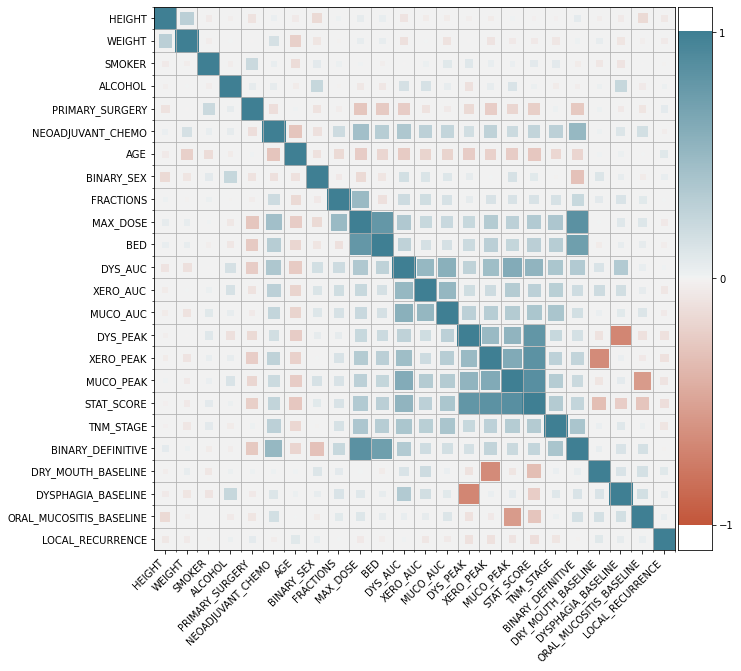

In [30]:
from heatmap import heatmap, corrplot
  
check_corr = df[['HEIGHT', 'WEIGHT', 'SMOKER', 'ALCOHOL', \
                 'PRIMARY_SURGERY', 'NEOADJUVANT_CHEMO', \
                 'AGE', 'BINARY_SEX', 'FRACTIONS', 'MAX_DOSE', \
                 'BED','DYS_AUC', 'XERO_AUC', 'MUCO_AUC',\
                 'DYS_PEAK', 'XERO_PEAK', 'MUCO_PEAK',\
                 'STAT_SCORE', 'CATEGORICAL_SITE', 'TNM_STAGE',\
                 'BINARY_DEFINITIVE', 'DRY_MOUTH_BASELINE', \
                 'DYSPHAGIA_BASELINE', 'ORAL_MUCOSITIS_BASELINE', 'LOCAL_RECURRENCE']]
plt.figure(figsize=(10, 10))
corrplot(check_corr.corr())
plt.savefig('CorrPlotMLModels.png')

## Creating KNN Model 
- Create df for the predictive variables and the class to predict as x,y
- Impute the missing information 
- Use the standard scaler to normalise values between 0-1 for all categories 
- Train, Test split for KNN 

In [3]:
# import libraries relevant for KNN model development 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc

In [32]:
# Set the features used for prediction (x) and the class that you want to predict (y) 
x = df[['HEIGHT', 'WEIGHT', 'SMOKER',
        'ALCOHOL', 'PRIMARY_SURGERY',
       'NEOADJUVANT_CHEMO', 'AGE', 'BINARY_SEX', 'FRACTIONS', 'MAX_DOSE', 
       'DYS_AUC', 'XERO_AUC', 'MUCO_AUC',
       'STAT_SCORE', 'CATEGORICAL_SITE', 'TNM_STAGE',
       'DRY_MOUTH_BASELINE', 'DYSPHAGIA_BASELINE', 'ORAL_MUCOSITIS_BASELINE']]

y = df[['LOCAL_RECURRENCE']]
y=list(y['LOCAL_RECURRENCE'])

## Use imputation to replace missing values in the dataset 

imputer = IterativeImputer(max_iter=100)
imputer.fit(x)
x_transform = imputer.transform(x)
print('Missing: %d' % sum(np.isnan(x_transform).flatten()))
imputed_x = pd.DataFrame(x_transform, columns=list(x.columns))
#imputed_x.to_csv('ImputedVoxToxData.csv')

## Train and Test KNN Model 
Functions for train and test, metric evaluation and hyperparameter optimisation 

In [51]:
def KNN_classifier(imputed_x, y, k_neighbors):
    predictions = {}
    error = []
    scaler = StandardScaler()

    for i in range(1,6): 
        x_train, x_test, y_train, y_test = train_test_split(imputed_x, y, test_size = 0.3)
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
        knn = KNeighborsClassifier(n_neighbors=k_neighbors)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error.append(np.mean(y_pred != y_test))
        predictions[i] = [y_test, y_pred]
        
    return predictions, error


def KNN_metrics(predictions):
    accuracy = []
    brier_score = []
    precision = []
    f1_score = []
    roc_auc = []
    
    
    for key in predictions.keys(): 
        con_matrix = confusion_matrix(predictions[key][0], predictions[key][1])
        class_report = classification_report(predictions[key][0], predictions[key][1])
        print(con_matrix, class_report)
        print(sklearn.metrics.accuracy_score(predictions[key][0], predictions[key][1]))
        print(sklearn.metrics.brier_score_loss(predictions[key][0], predictions[key][1]))
        
        accuracy.append(sklearn.metrics.accuracy_score(predictions[key][0], predictions[key][1]))
        brier_score.append(sklearn.metrics.brier_score_loss(predictions[key][0], predictions[key][1]))
        precision.append(sklearn.metrics.precision_score(predictions[key][0], predictions[key][1]))
        f1_score.append(sklearn.metrics.f1_score(predictions[key][0], predictions[key][1]))
        false_positive_rate, true_positive_rate, thresholds = roc_curve(predictions[key][0], predictions[key][1])
        auc_value = auc(false_positive_rate, true_positive_rate)
        roc_auc.append(auc_value)

    
    return accuracy, brier_score, precision, f1_score, roc_auc


def tune_parameters(imputed_x, y):
    errors = {}
    accuracies ={}
    scaler = StandardScaler()
    
    #for i in range(1,11):
    error = []
    accuracy = []
    for i in range(1,11): 
        x_train, x_test, y_train, y_test = train_test_split(imputed_x, y, test_size = 0.3)
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error.append(np.mean(y_pred != y_test))
        accuracy.append(sklearn.metrics.accuracy_score(y_test, y_pred))
        
        errors[i] = np.mean(y_pred != y_test)
        accuracies[i] = sklearn.metrics.accuracy_score(y_test, y_pred)
        
    return accuracies, errors   

In [45]:
# Tune hyperparameter (number of nearest neighbours)
accuracies, errors = tune_parameters(imputed_x, y)
print(np.max(list(accuracies.values())), np.min(list(errors.values())))
print(accuracies)

Text(0, 0.5, 'Mean Error')

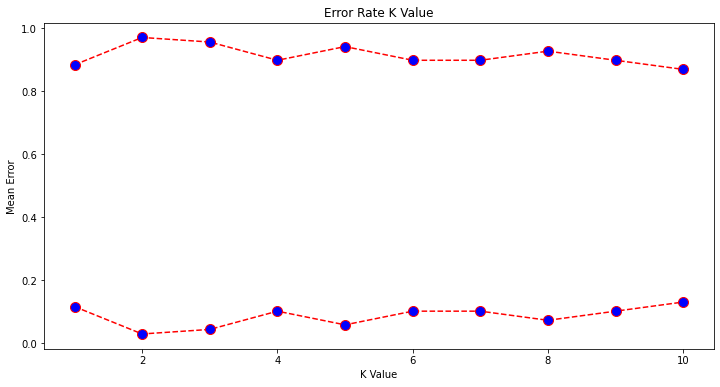

In [47]:
# Plot the mean error for each KNN model against the number of neighbours 
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), list(errors.values()), color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.plot(range(1, 11), list(accuracies.values()), color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [52]:
# print metrics for each iterations of KNN model 
predictions, error = KNN_classifier(imputed_x, y, 3)
accuracy, brier_score, precision, f1_score, auc = KNN_metrics(predictions)

[[63  0]
 [ 6  0]]               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        63
         1.0       0.00      0.00      0.00         6

    accuracy                           0.91        69
   macro avg       0.46      0.50      0.48        69
weighted avg       0.83      0.91      0.87        69

0.9130434782608695
0.08695652173913043
[[64  0]
 [ 5  0]]               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        64
         1.0       0.00      0.00      0.00         5

    accuracy                           0.93        69
   macro avg       0.46      0.50      0.48        69
weighted avg       0.86      0.93      0.89        69

0.927536231884058
0.07246376811594203
[[64  1]
 [ 4  0]]               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        65
         1.0       0.00      0.00      0.00         4

    accuracy                           0.93     

/Users/ceilidhwelsh/opt/anaconda3/envs/voxtox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ceilidhwelsh/opt/anaconda3/envs/voxtox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ceilidhwelsh/opt/anaconda3/envs/voxtox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [54]:
# Print the final metrics for KNN model 
print(np.mean(accuracy), np.mean(brier_score), np.mean(precision), np.mean(auc))

0.9362318840579709 0.06376811594202898 0.0 0.49846153846153846


---

## Visualising the Data using BoxPlots

In [ ]:
x = df[['STAT_SCORE', 'DYS_AUC', 'XERO_AUC', 'MUCO_AUC']]
y = df[['LOCAL_RECURRENCE']]
investigate = pd.concat([x,y], axis=1)

In [217]:
recurrence_df = investigate[investigate['LOCAL_RECURRENCE']==1.0].copy()
recurrence_df = recurrence_df.assign(Recurrence='Yes')

<AxesSubplot:>

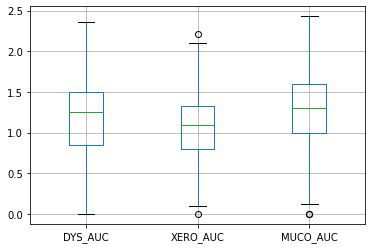

In [218]:
no_recurrence_df = investigate[investigate['LOCAL_RECURRENCE']!=1.0].copy()
no_recurrence_df = no_recurrence_df.assign(Recurrence='No')
no_recurrence_df.boxplot(column=['DYS_AUC', 'XERO_AUC', 'MUCO_AUC'])

<AxesSubplot:>

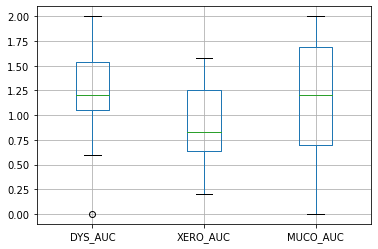

In [198]:
recurrence_df.boxplot(column=['DYS_AUC', 'XERO_AUC', 'MUCO_AUC'])

In [219]:
cdf = pd.concat([recurrence_df, no_recurrence_df])    
mdf = pd.melt(cdf, id_vars=['Recurrence'], var_name=['Endpoint'])
print(mdf.head())

  Recurrence    Endpoint     value
0        Yes  STAT_SCORE  0.003517
1        Yes  STAT_SCORE -0.682167
2        Yes  STAT_SCORE -1.422711
3        Yes  STAT_SCORE -0.761987
4        Yes  STAT_SCORE  0.003517


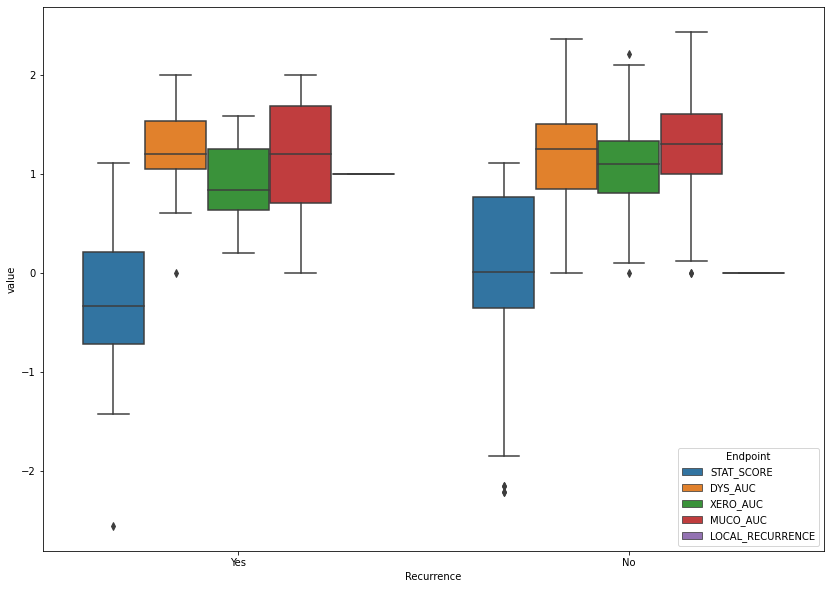

In [229]:
plt.figure(figsize=(14,10))
ax = sns.boxplot(x="Recurrence", y="value", hue="Endpoint", data=mdf)    
plt.show()

In [241]:
x = df[['DRY_MOUTH_BASELINE', 'DYSPHAGIA_BASELINE', 'ORAL_MUCOSITIS_BASELINE']]
y = df[['LOCAL_RECURRENCE']]
investigate2 = pd.concat([x,y], axis=1)
recurrence_df = investigate2[investigate2['LOCAL_RECURRENCE']==1.0].copy()
recurrence_df = recurrence_df.assign(Recurrence='Yes')
no_recurrence_df = investigate2[investigate2['LOCAL_RECURRENCE']!=1.0].copy()
no_recurrence_df = no_recurrence_df.assign(Recurrence='No')

In [242]:
cdf = pd.concat([recurrence_df, no_recurrence_df])    
mdf = pd.melt(cdf, id_vars=['Recurrence'], var_name=['Endpoint'])
print(mdf.head())

  Recurrence            Endpoint  value
0        Yes  DRY_MOUTH_BASELINE    0.0
1        Yes  DRY_MOUTH_BASELINE    2.0
2        Yes  DRY_MOUTH_BASELINE    1.0
3        Yes  DRY_MOUTH_BASELINE    1.0
4        Yes  DRY_MOUTH_BASELINE    0.0


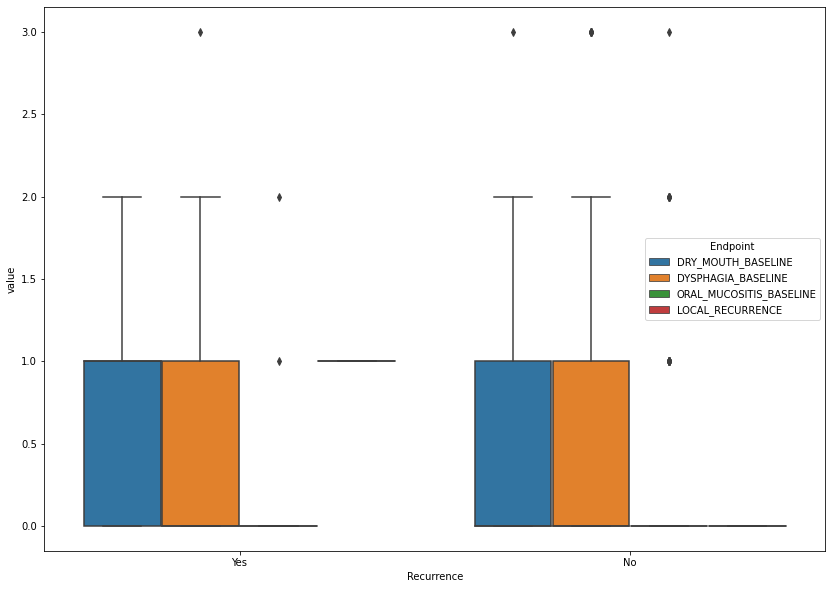

In [243]:
plt.figure(figsize=(14,10))
ax = sns.boxplot(x="Recurrence", y="value", hue="Endpoint", data=mdf)    
plt.show()

In [244]:
x = df[['DYS_PEAK', 'XERO_PEAK', 'MUCO_PEAK']]
y = df[['LOCAL_RECURRENCE']]
investigate3 = pd.concat([x,y], axis=1)
recurrence_df = investigate3[investigate3['LOCAL_RECURRENCE']==1.0].copy()
recurrence_df = recurrence_df.assign(Recurrence='Yes')
no_recurrence_df = investigate3[investigate3['LOCAL_RECURRENCE']!=1.0].copy()
no_recurrence_df = no_recurrence_df.assign(Recurrence='No')

  Recurrence  Endpoint  value
0        Yes  DYS_PEAK    2.0
1        Yes  DYS_PEAK    2.0
2        Yes  DYS_PEAK   -1.0
3        Yes  DYS_PEAK    1.0
4        Yes  DYS_PEAK    2.0


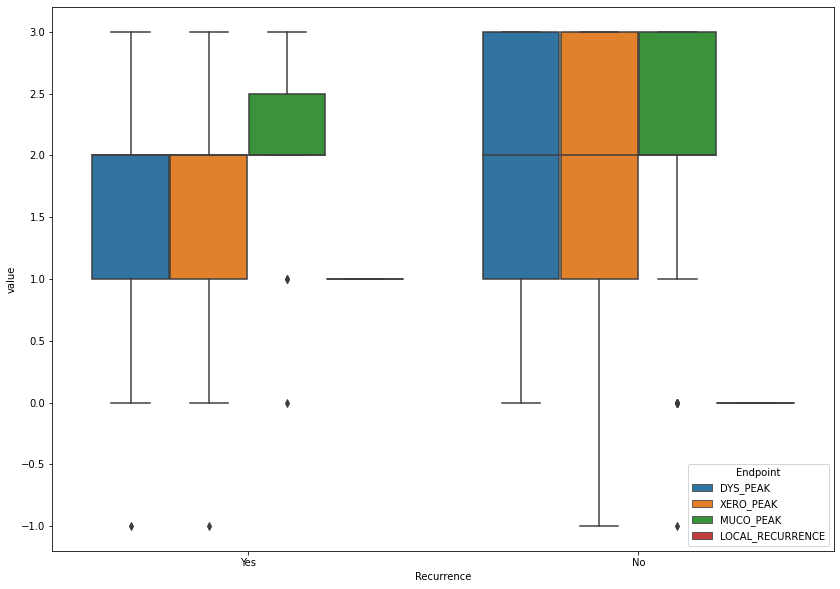

In [245]:
cdf = pd.concat([recurrence_df, no_recurrence_df])    
mdf = pd.melt(cdf, id_vars=['Recurrence'], var_name=['Endpoint'])
print(mdf.head())
plt.figure(figsize=(14,10))
ax = sns.boxplot(x="Recurrence", y="value", hue="Endpoint", data=mdf)    
plt.show()

In [263]:
x = df[['MAX_DOSE','BED']]
y = df[['LOCAL_RECURRENCE']]
investigate3 = pd.concat([x,y], axis=1)
recurrence_df = investigate3[investigate3['LOCAL_RECURRENCE']==1.0].copy()
recurrence_df = recurrence_df.assign(Recurrence='Yes')
no_recurrence_df = investigate3[investigate3['LOCAL_RECURRENCE']!=1.0].copy()
no_recurrence_df = no_recurrence_df.assign(Recurrence='No')

  Recurrence  Endpoint  value
0        Yes  MAX_DOSE   60.0
1        Yes  MAX_DOSE   65.0
2        Yes  MAX_DOSE   65.0
3        Yes  MAX_DOSE   65.0
4        Yes  MAX_DOSE   60.0


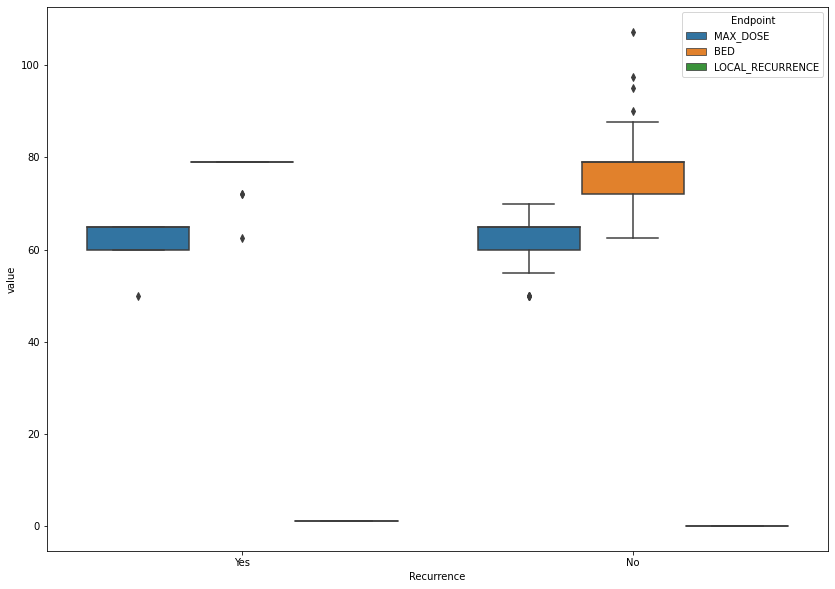

In [264]:
cdf = pd.concat([recurrence_df, no_recurrence_df])    
mdf = pd.melt(cdf, id_vars=['Recurrence'], var_name=['Endpoint'])
print(mdf.head())
plt.figure(figsize=(14,10))
ax = sns.boxplot(x="Recurrence", y="value", hue="Endpoint", data=mdf)    
plt.show()

<AxesSubplot:xlabel='BED', ylabel='Count'>

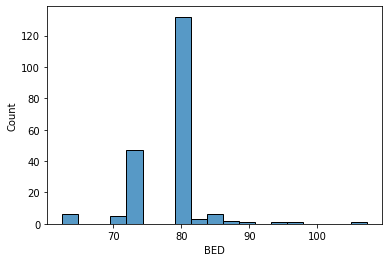

In [96]:
sns.histplot(df['BED'])

In [265]:
recurrence_df

,MAX_DOSE,BED,LOCAL_RECURRENCE,Recurrence
13,60.0,NaN,1.0,Yes
57,65.0,79.083333,1.0,Yes
75,65.0,79.083333,1.0,Yes
77,65.0,79.083333,1.0,Yes
97,60.0,72.000000,1.0,Yes
...,...,...,...,...
147,60.0,72.000000,1.0,Yes
151,65.0,79.083333,1.0,Yes
169,65.0,79.083333,1.0,Yes
184,65.0,79.083333,1.0,Yes
